# **Gesture Recognition**
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
from skimage.io import imread
import datetime
import random as rn
from keras import backend
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt

# Mounting Data

In [ ]:
#Mounting drive to import dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We set the random seed so that the results don't vary drastically.

In [ ]:
def reset_random_seeds():
  np.random.seed(30)  
  rn.seed(30)
  tf.random.set_seed(30)

In [ ]:
num_classes = 5
num_frames = 30
img_idx =  np.arange(0,num_frames,2) #feed in 15 image indexes

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
#Copying from Google Drive 
!cp /content/drive/MyDrive/ML/CNN/DataSet/Project_data.zip .
!unzip Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [ ]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())

# Utility Functions

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
image_x_shape = 100
image_y_shape = 100

In [ ]:
def generator(source_path, folder_list, batch_size, augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30, 3)) #create a list of image numbers you want to use for a particular video
    x, y, z = len(img_idx), image_x_shape, image_y_shape
    while True:
        t = np.random.permutation(folder_list)
        total_folders = len(folder_list)
        num_batches = total_folders // batch_size #<TODO># calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            if augment:
                batch_data_aug = np.zeros((batch_size,x,y,z,3))
                
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #Resizing images as we have images of 2 different shape 
                    #Please refer https://stackoverflow.com/questions/59907635/how-to-resize-an-image-but-maintain-pixel-values-in-sk-image
                    orignal_grayedImage = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                    #Numpy library function used to find the indices of array elements that are nonzero, grouped by element. 
                    x00, y00 = np.argwhere(orignal_grayedImage > 0).min(axis=0) #fixed assignment issue, Variable was referenced before assignment
                    x11, y11 = np.argwhere(orignal_grayedImage > 0).max(axis=0) #fixed assignment issue, Variable was referenced before assignment
                    #Cropping the images to have the targeted gestures and remove the noise from the images.
                    orignal_image_cropped=image[x00:x11,y00:y11, :]  #If you want to crop the image and include color channel, then we have to crop the original image not the grayscaled
                    #Making image of same size
                    resizedImage=resize(orignal_image_cropped,(y, z),anti_aliasing=True)
                    #resizedImage = resize(image, (y, z),anti_aliasing=True)
                    #and the Conv3D will throw error if the inputs in a batch have different shapes
                    
                    ### Normalize the data
                    resizedImage = resizedImage / 255 
                    ###
                    
                    ### Standardise the Data
                    batch_data[folder,idx,:,:,0] = (resizedImage[:, :, 0] - resizedImage[:, :, 0].mean()) / resizedImage[:, :, 0].std() #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resizedImage[:, :, 1] - resizedImage[:, :, 1].mean()) / resizedImage[:, :, 1].std()
                    batch_data[folder,idx,:,:,2] = (resizedImage[:, :, 2] - resizedImage[:, :, 2].mean()) / resizedImage[:, :, 2].std()
                    ###
                    
                    ### Data Augmentation with Tranformation and cropping images 
                    if augment:
                        #Affine transformation 
                        shifted = cv2.warpAffine(image,np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),(image.shape[1], image.shape[0]))
                        #Converting an image from one color space to another. 
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                        #Numpy library function used to find the indices of array elements that are nonzero, grouped by element. 
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        #Cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]
                        #Making image of same size
                        image_resized=resize(cropped,(y, z),anti_aliasing=True)
                        
                        ### Normalize the data
                        resizedImage = image_resized / 255 
                        ###

                        ### Standardise the Data
                        batch_data_aug[folder,idx,:,:,0] = (resizedImage[:, :, 0] - resizedImage[:, :, 0].mean()) / resizedImage[:, :, 0].std() #normalise and feed in the image
                        batch_data_aug[folder,idx,:,:,1] = (resizedImage[:, :, 1] - resizedImage[:, :, 1].mean()) / resizedImage[:, :, 1].std()
                        batch_data_aug[folder,idx,:,:,2] = (resizedImage[:, :, 2] - resizedImage[:, :, 2].mean()) / resizedImage[:, :, 2].std()
                        ###
                            
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches    
        missing_count = total_folders - (num_batches * batch_size)
        if missing_count != 0:
            batch_data = np.zeros((missing_count,x,y,z,3))
            batch_labels = np.zeros((missing_count,5))
            
            if augment:
                batch_data_aug2 = np.zeros((missing_count,x,y,z,3))            
                
            for folder in range(missing_count):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    orignal_grayedImage = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                    #Numpy library function used to find the indices of array elements that are nonzero, grouped by element. 
                    x00, y00 = np.argwhere(orignal_grayedImage > 0).min(axis=0)
                    x11, y11 = np.argwhere(orignal_grayedImage > 0).max(axis=0)
                    #Cropping the images to have the targeted gestures and remove the noise from the images.
                    orignal_image_cropped=image[x00:x11,y00:y11,:]
                    #Making image of same size
                    resizedImage=resize(orignal_image_cropped,(y, z),anti_aliasing=True)
                    #and the Conv3D will throw error if the inputs in a batch have different shapes

                    ### Normalize the data
                    resizedImage = resizedImage / 255 
                    ###

                    ### Standardise the Data
                    batch_data[folder,idx,:,:,0] = (resizedImage[:, :, 0] - resizedImage[:, :, 0].mean()) / resizedImage[:, :, 0].std() #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resizedImage[:, :, 1] - resizedImage[:, :, 1].mean()) / resizedImage[:, :, 1].std()
                    batch_data[folder,idx,:,:,2] = (resizedImage[:, :, 2] - resizedImage[:, :, 2].mean()) / resizedImage[:, :, 2].std()
                    ###

                    if augment:

                        shifted = cv2.warpAffine(image,np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),(image.shape[1], image.shape[0]))
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]
                        image_resized=resize(cropped,(y, z),anti_aliasing=True)

                        ### Normalize the data
                        resizedImage = image_resized / 255 
                        ###

                        ### Standardise the Data
                        batch_data_aug2[folder,idx,:,:,0] = (resizedImage[:, :, 0] - resizedImage[:, :, 0].mean()) / resizedImage[:, :, 0].std() #normalise and feed in the image
                        batch_data_aug2[folder,idx,:,:,1] = (resizedImage[:, :, 1] - resizedImage[:, :, 1].mean()) / resizedImage[:, :, 1].std()
                        batch_data_aug2[folder,idx,:,:,2] = (resizedImage[:, :, 2] - resizedImage[:, :, 2].mean()) / resizedImage[:, :, 2].std()
                        ###


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug2])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                
        yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Plot Model Performance

In [ ]:
#Plotting function to check for accuracy with graphs 
def plot_model_performance(epochs, history):

  #getting train and validation accuracy
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  #getting train and validation loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(25, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

## Save Train Model

In [ ]:
def save_train_model (batch_size, num_train_sequences):
  global model_name ,filepath ,callbacks_list ,steps_per_epoch,validation_steps
  print("Used batch_size:{} and num_train_sequences {} ".format(batch_size,num_train_sequences))
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
      
  if not os.path.exists(model_name):
      os.mkdir(model_name)
          
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

  LR =  ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 2,
                              verbose = 1, mode = "auto", cooldown = 0)

  callbacks_list = [checkpoint, LR]

  #The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make. 
  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10 #experiment with the batch size

# training sequences = 663
# validation sequences = 100
# epochs = 20


#  Model Build , Train
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv2D,Conv3D, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.regularizers import l2
import tensorflow.keras


## **Model 1** : Time Distributed CNN2d + LSTM

https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

In [ ]:
reset_random_seeds()

In [ ]:
        cnn2d_ltsm = Sequential()
        cnn2d_ltsm.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn2d_ltsm.add(TimeDistributed(Activation('relu')))
        cnn2d_ltsm.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn2d_ltsm.add(TimeDistributed(BatchNormalization()))
        
        cnn2d_ltsm.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn2d_ltsm.add(TimeDistributed(Activation('relu')))
        cnn2d_ltsm.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn2d_ltsm.add(TimeDistributed(BatchNormalization()))
        
        cnn2d_ltsm.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_ltsm.add(TimeDistributed(Activation('relu')))
        cnn2d_ltsm.add(TimeDistributed(BatchNormalization()))
        cnn2d_ltsm.add(Dropout(0.25))
        
        cnn2d_ltsm.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_ltsm.add(TimeDistributed(Activation('relu')))
        
        
        cnn2d_ltsm.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn2d_ltsm.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn2d_ltsm.add(TimeDistributed(Activation('relu')))
        
        cnn2d_ltsm.add(Dropout(0.25))
        
        cnn2d_ltsm.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_ltsm.add(TimeDistributed(Activation('relu')))

        cnn2d_ltsm.add(Dropout(0.50))
        
        cnn2d_ltsm.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_ltsm.add(TimeDistributed(Activation('relu')))

        
        cnn2d_ltsm.add(TimeDistributed(Flatten()))
        cnn2d_ltsm.add(LSTM(64, return_sequences=False))
        cnn2d_ltsm.add(Dropout(.2))
        cnn2d_ltsm.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.SGD() #write your optimizer
cnn2d_ltsm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn2d_ltsm.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_135 (TimeD  (None, 10, 100, 100, 32)  128      
 istributed)                                                     
                                                                 
 time_distributed_136 (TimeD  (None, 10, 100, 100, 32)  0        
 istributed)                                                     
                                                                 
 time_distributed_137 (TimeD  (None, 10, 49, 49, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_138 (TimeD  (None, 10, 49, 49, 32)   128       
 istributed)                                                     
                                                                 
 time_distributed_139 (TimeD  (None, 10, 49, 49, 32) 

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=False)
val_generator = generator(val_path, val_doc, batch_size,augment=False)

In [ ]:
save_train_model(batch_size, num_train_sequences)

Used batch_size:10 and num_train_sequences 663 


In [ ]:
lstm_model_history = cnn2d_ltsm.fit(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=num_epochs,
                                  verbose=1,
                                  callbacks=callbacks_list,
                                  validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  class_weight=None,
                                  workers=1,
                                  initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 5.2187 - categorical_accuracy: 0.2066Source path =  ./Project_data/val ; batch size = 10

Epoch 1: saving model to model_init_2022-09-0605_50_25.806355/model-00001-5.21867-0.20664-5.12756-0.21000.h5
67/67 [==============================] - 92s 1s/step - loss: 5.2187 - categorical_accuracy: 0.2066 - val_loss: 5.1276 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 5.0081 - categorical_accuracy: 0.3258
Epoch 2: saving model to model_init_2022-09-0605_50_25.806355/model-00002-5.00808-0.32579-4.95491-0.43000.h5
67/67 [==============================] - 88s 1s/step - loss: 5.0081 - categorical_accuracy: 0.3258 - val_loss: 4.9549 - val_categorical_accuracy: 0.4300 - lr: 0.0100
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 4.6666 - categorical_accuracy: 0.4962
Epoch 3: saving model to m

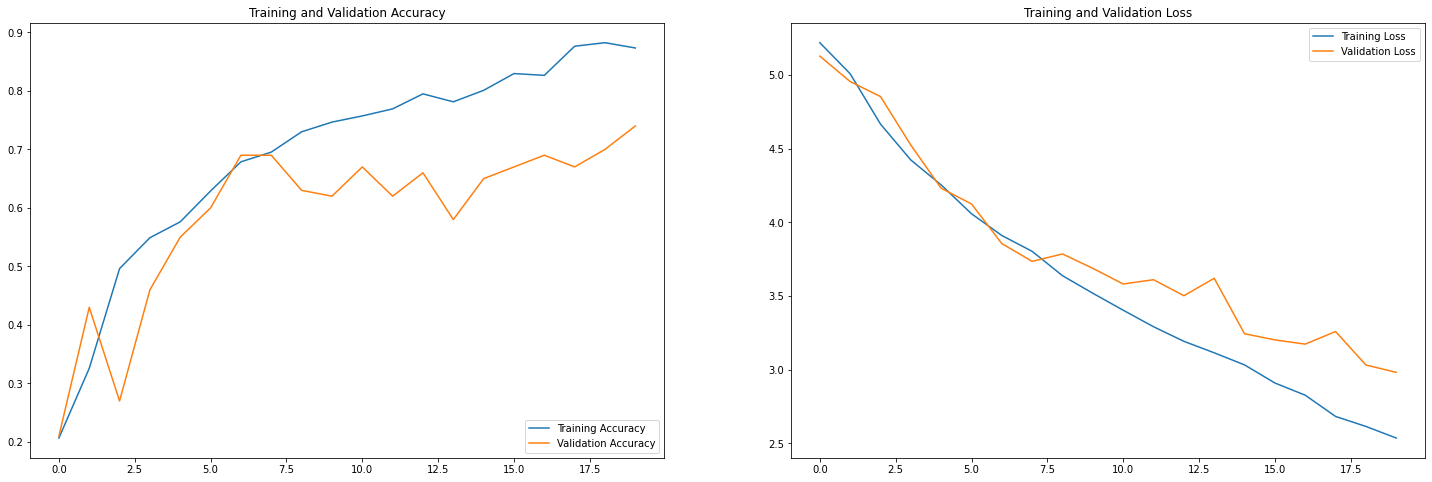

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, lstm_model_history)

### **Analysis**



*   Training Accuracy % : 87 
*   Validation Accuracy : 74
*   Overfitting can be reduced  




## Model 2: CNN2D + GRU

In [ ]:
reset_random_seeds()

In [ ]:
        cnn2d_gru_model = Sequential()
        cnn2d_gru_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn2d_gru_model.add(TimeDistributed(Activation('relu')))
        cnn2d_gru_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn2d_gru_model.add(TimeDistributed(BatchNormalization()))
        
        cnn2d_gru_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn2d_gru_model.add(TimeDistributed(Activation('relu')))
        cnn2d_gru_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn2d_gru_model.add(TimeDistributed(BatchNormalization()))
        
        cnn2d_gru_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_model.add(TimeDistributed(Activation('relu')))
        cnn2d_gru_model.add(TimeDistributed(BatchNormalization()))
        cnn2d_gru_model.add(Dropout(0.25))
        
        cnn2d_gru_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn2d_gru_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn2d_gru_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn2d_gru_model.add(TimeDistributed(Activation('relu')))
        
        cnn2d_gru_model.add(Dropout(0.25))
        
        cnn2d_gru_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_model.add(TimeDistributed(Activation('relu')))

        cnn2d_gru_model.add(Dropout(0.50))
        
        cnn2d_gru_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_model.add(TimeDistributed(Activation('relu')))

        
        cnn2d_gru_model.add(TimeDistributed(Flatten()))
        cnn2d_gru_model.add(Dense(16, activation='relu'))
        cnn2d_gru_model.add(Dropout(.2))
        cnn2d_gru_model.add(GRU(64, return_sequences=False))
        cnn2d_gru_model.add(Dropout(.2))
        cnn2d_gru_model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.SGD() #write your optimizer
cnn2d_gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn2d_gru_model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_156 (TimeD  (None, 10, 100, 100, 32)  128      
 istributed)                                                     
                                                                 
 time_distributed_157 (TimeD  (None, 10, 100, 100, 32)  0        
 istributed)                                                     
                                                                 
 time_distributed_158 (TimeD  (None, 10, 49, 49, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_159 (TimeD  (None, 10, 49, 49, 32)   128       
 istributed)                                                     
                                                                 
 time_distributed_160 (TimeD  (None, 10, 49, 49, 32) 

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=False)
val_generator = generator(val_path, val_doc, batch_size,augment=False)

In [ ]:
save_train_model(batch_size, num_train_sequences)

Used batch_size:10 and num_train_sequences 663 


In [ ]:
lstm_model_history = cnn2d_gru_model.fit(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=num_epochs,
                                  verbose=1,
                                  callbacks=callbacks_list,
                                  validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  class_weight=None,
                                  workers=1,
                                  initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 5.1944 - categorical_accuracy: 0.2036Source path =  ./Project_data/val ; batch size = 10

Epoch 1: saving model to model_init_2022-09-0605_50_25.806355/model-00001-5.19441-0.20362-5.14094-0.21000.h5
67/67 [==============================] - 81s 1s/step - loss: 5.1944 - categorical_accuracy: 0.2036 - val_loss: 5.1409 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 5.1011 - categorical_accuracy: 0.1840
Epoch 2: saving model to model_init_2022-09-0605_50_25.806355/model-00002-5.10105-0.18401-5.04657-0.21000.h5
67/67 [==============================] - 85s 1s/step - loss: 5.1011 - categorical_accuracy: 0.1840 - val_loss: 5.0466 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 5.0044 - categorical_accuracy: 0.2187
Epoch 3: saving model to m

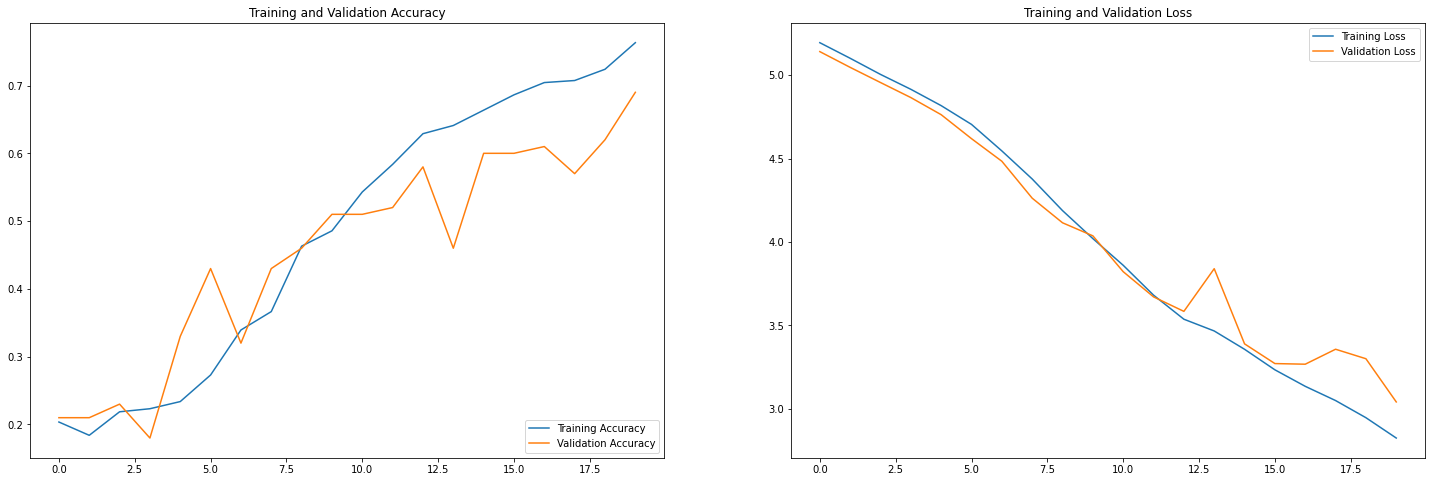

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, lstm_model_history)

### **Analysis**



*   Training Accuracy % : 76 
*   Validation Accuracy % : 69
*   Overfitting reduced but results not good 




## Model 3: Conv2D + GRU (Epochs = 30, Batch Size = 60) + Data Augmentation

In [ ]:
reset_random_seeds()

In [ ]:
        cnn2d_gru_aug_model = Sequential()
        cnn2d_gru_aug_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn2d_gru_aug_model.add(TimeDistributed(Activation('relu')))
        cnn2d_gru_aug_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn2d_gru_aug_model.add(TimeDistributed(BatchNormalization()))
        
        cnn2d_gru_aug_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn2d_gru_aug_model.add(TimeDistributed(Activation('relu')))
        cnn2d_gru_aug_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn2d_gru_aug_model.add(TimeDistributed(BatchNormalization()))
        
        cnn2d_gru_aug_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_aug_model.add(TimeDistributed(Activation('relu')))
        cnn2d_gru_aug_model.add(TimeDistributed(BatchNormalization()))
        cnn2d_gru_aug_model.add(Dropout(0.25))
        
        cnn2d_gru_aug_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_aug_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn2d_gru_aug_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn2d_gru_aug_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn2d_gru_aug_model.add(TimeDistributed(Activation('relu')))
        
        cnn2d_gru_aug_model.add(Dropout(0.25))
        
        cnn2d_gru_aug_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_aug_model.add(TimeDistributed(Activation('relu')))

        cnn2d_gru_aug_model.add(Dropout(0.50))
        
        cnn2d_gru_aug_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_aug_model.add(TimeDistributed(Activation('relu')))

        
        cnn2d_gru_aug_model.add(TimeDistributed(Flatten()))
        cnn2d_gru_aug_model.add(Dense(16, activation='relu'))
        cnn2d_gru_aug_model.add(Dropout(.2))
        cnn2d_gru_aug_model.add(GRU(64, return_sequences=False))
        cnn2d_gru_aug_model.add(Dropout(.2))
        cnn2d_gru_aug_model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.SGD() #write your optimizer
cnn2d_gru_aug_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn2d_gru_aug_model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_177 (TimeD  (None, 10, 100, 100, 32)  128      
 istributed)                                                     
                                                                 
 time_distributed_178 (TimeD  (None, 10, 100, 100, 32)  0        
 istributed)                                                     
                                                                 
 time_distributed_179 (TimeD  (None, 10, 49, 49, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_180 (TimeD  (None, 10, 49, 49, 32)   128       
 istributed)                                                     
                                                                 
 time_distributed_181 (TimeD  (None, 10, 49, 49, 32) 

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

In [ ]:
save_train_model(batch_size, num_train_sequences)

Used batch_size:10 and num_train_sequences 663 


In [ ]:
lstm_model_history = cnn2d_gru_aug_model.fit(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=num_epochs,
                                  verbose=1,
                                  callbacks=callbacks_list,
                                  validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  class_weight=None,
                                  workers=1,
                                  initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 5.1982 - categorical_accuracy: 0.1885Source path =  ./Project_data/val ; batch size = 10

Epoch 1: saving model to model_init_2022-09-0605_50_25.806355/model-00001-5.19816-0.18854-5.14161-0.21000.h5
67/67 [==============================] - 148s 2s/step - loss: 5.1982 - categorical_accuracy: 0.1885 - val_loss: 5.1416 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 5.0976 - categorical_accuracy: 0.1976
Epoch 2: saving model to model_init_2022-09-0605_50_25.806355/model-00002-5.09761-0.19759-5.04652-0.20000.h5
67/67 [==============================] - 147s 2s/step - loss: 5.0976 - categorical_accuracy: 0.1976 - val_loss: 5.0465 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 5.0017 - categorical_accuracy: 0.2157
Epoch 3: saving model to

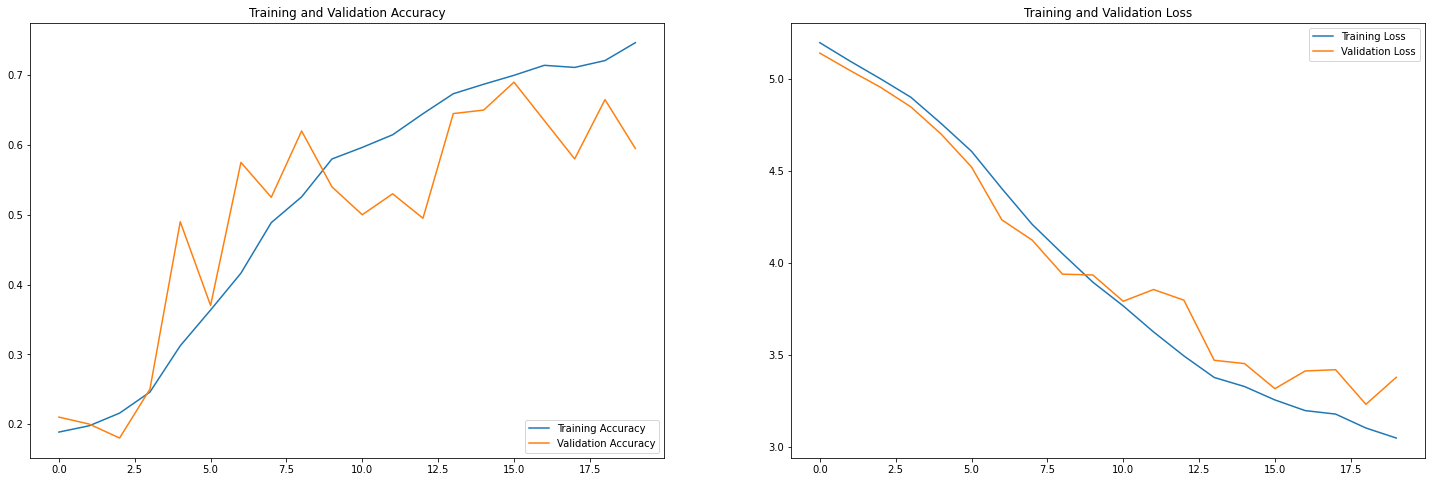

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, lstm_model_history)

### **Analysis**



*   Training Accuracy % : 74 
*   Validation Accuracy %: 59
*   DA dint helped much




## Model 4 : UPdating Image size Conv2D + GRU (Epochs = 30, Batch Size = 60) + Data Augmentation

In [ ]:
reset_random_seeds()
image_x_shape = 180
image_y_shape = 180

In [ ]:
        cnn2d_gru_aug_image_model = Sequential()
        cnn2d_gru_aug_image_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn2d_gru_aug_image_model.add(TimeDistributed(Activation('relu')))
        cnn2d_gru_aug_image_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn2d_gru_aug_image_model.add(TimeDistributed(BatchNormalization()))
        
        cnn2d_gru_aug_image_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn2d_gru_aug_image_model.add(TimeDistributed(Activation('relu')))
        cnn2d_gru_aug_image_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn2d_gru_aug_image_model.add(TimeDistributed(BatchNormalization()))
        
        cnn2d_gru_aug_image_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_aug_image_model.add(TimeDistributed(Activation('relu')))
        cnn2d_gru_aug_image_model.add(TimeDistributed(BatchNormalization()))
        cnn2d_gru_aug_image_model.add(Dropout(0.25))
        
        cnn2d_gru_aug_image_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_aug_image_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn2d_gru_aug_image_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn2d_gru_aug_image_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn2d_gru_aug_image_model.add(TimeDistributed(Activation('relu')))
        
        cnn2d_gru_aug_image_model.add(Dropout(0.25))
        
        cnn2d_gru_aug_image_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_aug_image_model.add(TimeDistributed(Activation('relu')))

        cnn2d_gru_aug_image_model.add(Dropout(0.50))
        
        cnn2d_gru_aug_image_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn2d_gru_aug_image_model.add(TimeDistributed(Activation('relu')))

        
        cnn2d_gru_aug_image_model.add(TimeDistributed(Flatten()))
        cnn2d_gru_aug_image_model.add(Dense(16, activation='relu'))
        cnn2d_gru_aug_image_model.add(Dropout(.2))
        cnn2d_gru_aug_image_model.add(GRU(64, return_sequences=False))
        cnn2d_gru_aug_image_model.add(Dropout(.2))
        cnn2d_gru_aug_image_model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.SGD() #write your optimizer
cnn2d_gru_aug_image_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn2d_gru_aug_image_model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_198 (TimeD  (None, 10, 180, 180, 32)  128      
 istributed)                                                     
                                                                 
 time_distributed_199 (TimeD  (None, 10, 180, 180, 32)  0        
 istributed)                                                     
                                                                 
 time_distributed_200 (TimeD  (None, 10, 89, 89, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_201 (TimeD  (None, 10, 89, 89, 32)   128       
 istributed)                                                     
                                                                 
 time_distributed_202 (TimeD  (None, 10, 89, 89, 32) 

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

In [ ]:
save_train_model(batch_size, num_train_sequences)

Used batch_size:10 and num_train_sequences 663 


In [ ]:
lstm_model_history = cnn2d_gru_aug_image_model.fit(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=num_epochs,
                                  verbose=1,
                                  callbacks=callbacks_list,
                                  validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  class_weight=None,
                                  workers=1,
                                  initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 5.2011 - categorical_accuracy: 0.1998Source path =  ./Project_data/val ; batch size = 10

Epoch 1: saving model to model_init_2022-09-0605_50_25.806355/model-00001-5.20113-0.19985-5.14126-0.21000.h5
67/67 [==============================] - 177s 3s/step - loss: 5.2011 - categorical_accuracy: 0.1998 - val_loss: 5.1413 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 5.0976 - categorical_accuracy: 0.1938
Epoch 2: saving model to model_init_2022-09-0605_50_25.806355/model-00002-5.09763-0.19382-5.04887-0.21000.h5
67/67 [==============================] - 179s 3s/step - loss: 5.0976 - categorical_accuracy: 0.1938 - val_loss: 5.0489 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 5.0051 - categorical_accuracy: 0.2006
Epoch 3: saving model to

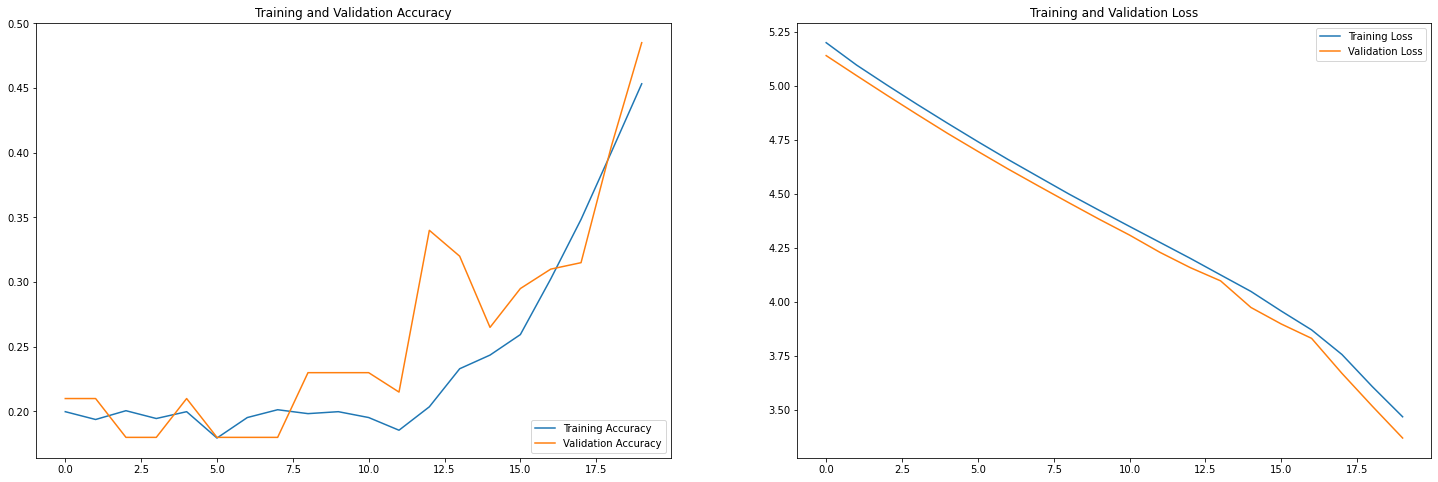

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, lstm_model_history)

### **Analysis**



*   Training Accuracy % : 45 
*   Validation Accuracy %: 48
*   Underfit




**Conv3DModels**

## **Model 5**  Conv3D +Adam

In [ ]:
reset_random_seeds()

In [ ]:
#Define the sequential model
model = Sequential()

#Added convolutional layers
#Applied 8 convolution filters of size 3x3x3 each, with even padding of around the images
model.add(Conv3D(8, (3, 3, 3), padding='same',input_shape=(10, image_x_shape, image_y_shape, 3)))
model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2x2
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Applied 16 convolution filters of size 3x3x3 each, with even padding of around the images
model.add(Conv3D(16, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2x2
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Applied 32 convolution filters of size 3x3x3 each, with even padding of around the images
model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2x2
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Applied dropout and set the rate to 50%
model.add(Dropout(0.5))

#Added a flatten layer followed by two dense layers
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dense(num_classes, activation = "softmax"))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
#KeyError: 'Failed to format this callback filepath: "model_init_2022-09-0522_20_29.424446/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5". Reason: \'categorical_accuracy\''

optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 10, 100, 100, 8)   656       
                                                                 
 activation_45 (Activation)  (None, 10, 100, 100, 8)   0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 5, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 50, 50, 16)     3472      
                                                                 
 activation_46 (Activation)  (None, 5, 50, 50, 16)     0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 2, 25, 25, 16)    0         
 g3D)                                                

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=False)
val_generator = generator(val_path, val_doc, batch_size,augment=False)

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10
save_train_model(batch_size, num_train_sequences)

# epochs = 20
Used batch_size:10 and num_train_sequences 663 


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:


va_con3d_model_history = model.fit(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=num_epochs,
                                  verbose=1,
                                  callbacks=callbacks_list,
                                  validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  class_weight=None,
                                  workers=1,
                                  initial_epoch=0)


Source path =  ./Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6414 - categorical_accuracy: 0.2489Source path =  ./Project_data/val ; batch size = 10

Epoch 1: saving model to model_init_2022-09-0605_50_25.806355/model-00001-1.64136-0.24887-1.56146-0.34000.h5
67/67 [==============================] - 81s 1s/step - loss: 1.6414 - categorical_accuracy: 0.2489 - val_loss: 1.5615 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.5407 - categorical_accuracy: 0.3092
Epoch 2: saving model to model_init_2022-09-0605_50_25.806355/model-00002-1.54070-0.30920-1.52856-0.31000.h5
67/67 [==============================] - 85s 1s/step - loss: 1.5407 - categorical_accuracy: 0.3092 - val_loss: 1.5286 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.3257 - categorical_accuracy: 0.4419
Epoch 3: saving model to m

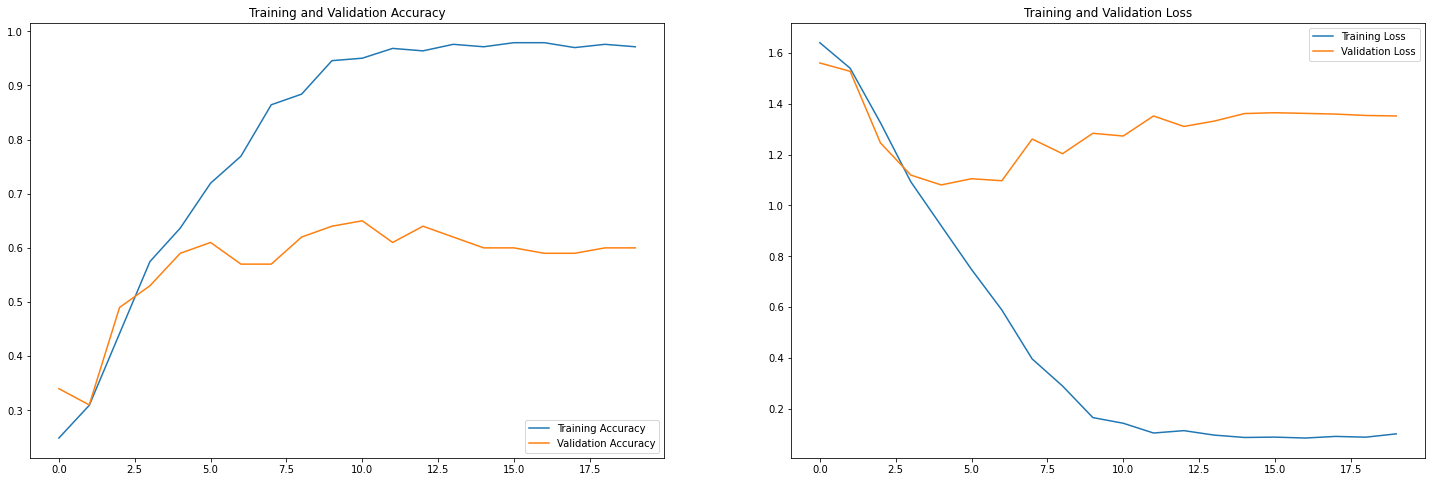

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, va_con3d_model_history)

### Analysis 


*   categorical_accuracy % : 97 %
*   val_categorical_accuracy % : 60 %
*   Seems to be overfit 



## Model 6: Conv3D + SGD

In [ ]:
reset_random_seeds()

In [ ]:
batch_size=30
model = Sequential()

model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(0.01),
                bias_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(0.01),
                bias_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())


model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(0.01),
                bias_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
model.add(BatchNormalization())

model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(0.01),
                bias_regularizer=regularizers.l2(0.01)))

model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                  kernel_regularizer=regularizers.l2(0.01),
                bias_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
model.add(BatchNormalization())


model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [ ]:
num_epochs=30
image_x_shape = 100
image_y_shape = 100

train_generator = generator(train_path, train_doc, batch_size,augment=False)
val_generator = generator(val_path, val_doc, batch_size,augment=False)

Conv3D_optimiser = optimizers.SGD() #write your optimizer

model.compile(optimizer=Conv3D_optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 100, 100, 8)   656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 50, 50, 8)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 5, 50, 50, 8)     32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 25, 25, 16)    0         
 3D)                                                             
                                                        

In [ ]:
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


In [ ]:
Conv3D_model_history = model.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 3.8797 - categorical_accuracy: 0.2112Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-0917_43_48.176850/model-00001-3.87965-0.21116-3.52633-0.27000.h5
23/23 [==============================] - 107s 4s/step - loss: 3.8797 - categorical_accuracy: 0.2112 - val_loss: 3.5263 - val_categorical_accuracy: 0.2700 - lr: 0.0100
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 3.7459 - categorical_accuracy: 0.2293
Epoch 2: saving model to model_init_2022-09-0917_43_48.176850/model-00002-3.74593-0.22926-3.51952-0.33000.h5
23/23 [==============================] - 88s 4s/step - loss: 3.7459 - categorical_accuracy: 0.2293 - val_loss: 3.5195 - val_categorical_accuracy: 0.3300 - lr: 0.0100
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 3.7001 - categorical_accuracy: 0.2323
Epoch 3: saving model to 

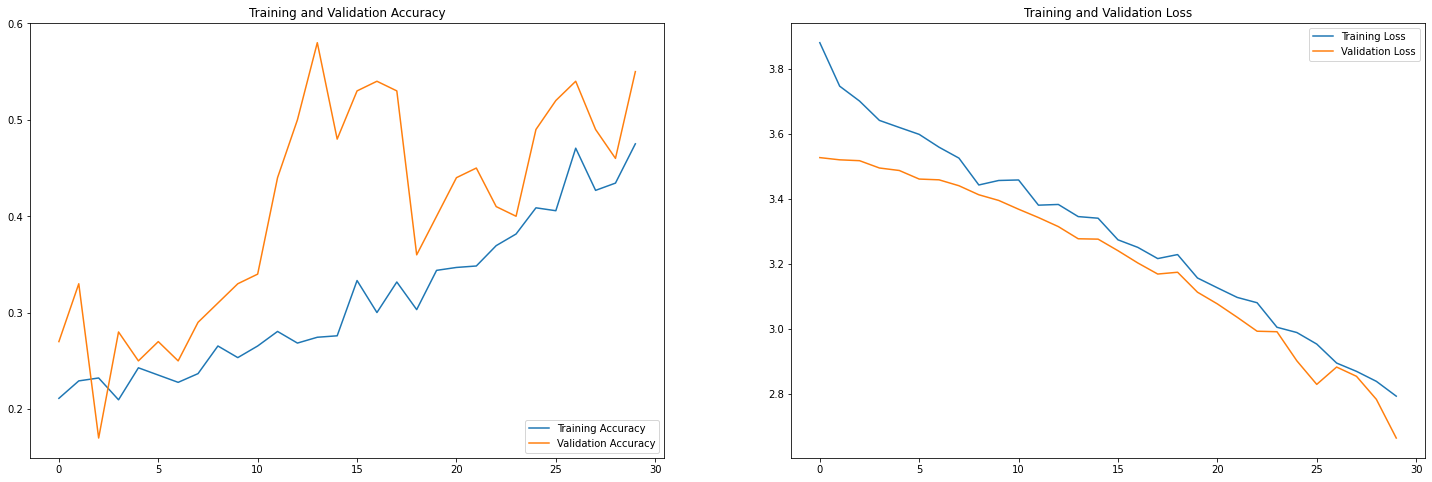

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, Conv3D_model_history)

### Analysis 


*   categorical_accuracy % : 97 %
*   val_categorical_accuracy % : 60 %
*   Seems to be overfit 



## Model 7: Conv3D + Augmentation + diff image size

In [ ]:
reset_random_seeds()

In [ ]:
batch_size=30
image_x_shape = 180
image_y_shape = 180

In [ ]:
#Define the sequential model
model_8 = Sequential()

#Added convolutional layers
#Applied 8 convolution filters of size 3x3x3 each, with even padding of around the images
model_8.add(Conv3D(8, (3, 3, 3), padding='same',input_shape=(10, image_x_shape, image_y_shape, 3)))
model_8.add(Activation('relu'))
#Added a max pooling layer of window size 2X2x2
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_8.add(BatchNormalization())

#Applied 16 convolution filters of size 3x3x3 each, with even padding of around the images
model_8.add(Conv3D(16, (3, 3, 3), padding='same'))
model_8.add(Activation('relu'))
#Added a max pooling layer of window size 2X2x2
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_8.add(BatchNormalization())

#Applied 32 convolution filters of size 3x3x3 each, with even padding of around the images
model_8.add(Conv3D(32, (3, 3, 3), padding='same'))
model_8.add(Activation('relu'))
#Added a max pooling layer of window size 2X2x2
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_8.add(BatchNormalization())

#Applied dropout and set the rate to 50%
model_8.add(Dropout(0.5))

#Added a flatten layer followed by two dense layers
model_8.add(Flatten())
model_8.add(Dense(64, activation = "relu"))
model_8.add(Dense(num_classes, activation = "softmax"))

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

optimiser = Adam(learning_rate=0.001)

model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_8.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 180, 180, 8)   656       
                                                                 
 activation (Activation)     (None, 10, 180, 180, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 90, 90, 8)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 5, 90, 90, 8)     32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 90, 90, 16)     3472      
                                                                 
 activation_1 (Activation)   (None, 5, 90, 90, 16)     0

In [ ]:
batch_size = 30
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


In [ ]:
model_8_history = model_8.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.8284 - categorical_accuracy: 0.3831Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-0616_53_40.912067/model-00001-1.82841-0.38311-2.00450-0.23000.h5
23/23 [==============================] - 222s 10s/step - loss: 1.8284 - categorical_accuracy: 0.3831 - val_loss: 2.0045 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.9763 - categorical_accuracy: 0.6576
Epoch 2: saving model to model_init_2022-09-0616_53_40.912067/model-00002-0.97630-0.65762-1.53430-0.37000.h5
23/23 [==============================] - 196s 9s/step - loss: 0.9763 - categorical_accuracy: 0.6576 - val_loss: 1.5343 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.7844 - categorical_accuracy: 0.7081
Epoch 3: saving model t

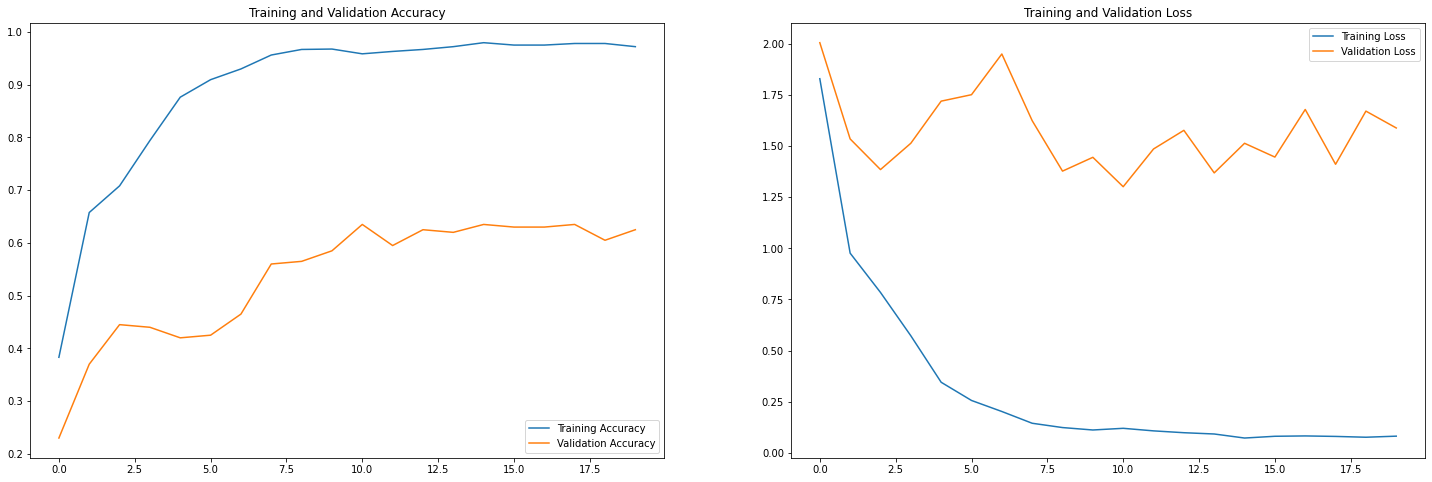

In [ ]:
#plot performance
#plotting graph to visualize model performance
plot_model_performance(num_epochs, model_8_history)

### Analysis 


*   categorical_accuracy % : 97 %
*   val_categorical_accuracy % : 62 %
*   Seems to be overfit 



## Model 8 : Conv3D + ADAM With more layers and l2 regularizer

In [ ]:
reset_random_seeds()

In [ ]:
        batch_size=30
        num_epochs=30
        image_x_shape = 100
        image_y_shape = 100

        model3D_ADAM = Sequential()
      
        model3D_ADAM.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
        model3D_ADAM.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM.add(BatchNormalization())
        
        model3D_ADAM.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM.add(BatchNormalization())
        
        model3D_ADAM.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM.add(BatchNormalization())
        
        
        model3D_ADAM.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model3D_ADAM.add(BatchNormalization())
        
        model3D_ADAM.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model3D_ADAM.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model3D_ADAM.add(BatchNormalization())
        
        model3D_ADAM.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model3D_ADAM.add(BatchNormalization())
        
       
        model3D_ADAM.add(Dropout(0.25))
        model3D_ADAM.add(Flatten())
        model3D_ADAM.add(Dense(256,activation='relu'))
        model3D_ADAM.add(Dropout(0.5))
        model3D_ADAM.add(Dense(128,activation='relu'))
        model3D_ADAM.add(Dropout(0.5))
        model3D_ADAM.add(Dense(64,activation='relu'))
        model3D_ADAM.add(Dropout(0.5))
        model3D_ADAM.add(Dense(5, activation='softmax'))

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=False)
val_generator = generator(val_path, val_doc, batch_size,augment=False)
Conv3D_optimiser = optimizers.SGD() #write your optimizer
model3D_ADAM.compile(optimizer=Conv3D_optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3D_ADAM.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 10, 100, 100, 8)   656       
                                                                 
 max_pooling3d_33 (MaxPoolin  (None, 5, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_33 (Bat  (None, 5, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_34 (Conv3D)          (None, 5, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_34 (MaxPoolin  (None, 2, 25, 25, 16)    0         
 g3D)                                                            
                                                      

In [ ]:
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


In [ ]:
Conv3D_model_history = model3D_ADAM.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 3.8980 - categorical_accuracy: 0.2127Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-0616_53_40.912067/model-00001-3.89803-0.21267-3.54135-0.18000.h5
23/23 [==============================] - 95s 4s/step - loss: 3.8980 - categorical_accuracy: 0.2127 - val_loss: 3.5413 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 3.7135 - categorical_accuracy: 0.2202
Epoch 2: saving model to model_init_2022-09-0616_53_40.912067/model-00002-3.71354-0.22021-3.52690-0.27000.h5
23/23 [==============================] - 89s 4s/step - loss: 3.7135 - categorical_accuracy: 0.2202 - val_loss: 3.5269 - val_categorical_accuracy: 0.2700 - lr: 0.0100
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 3.7122 - categorical_accuracy: 0.2112
Epoch 3: saving model to m

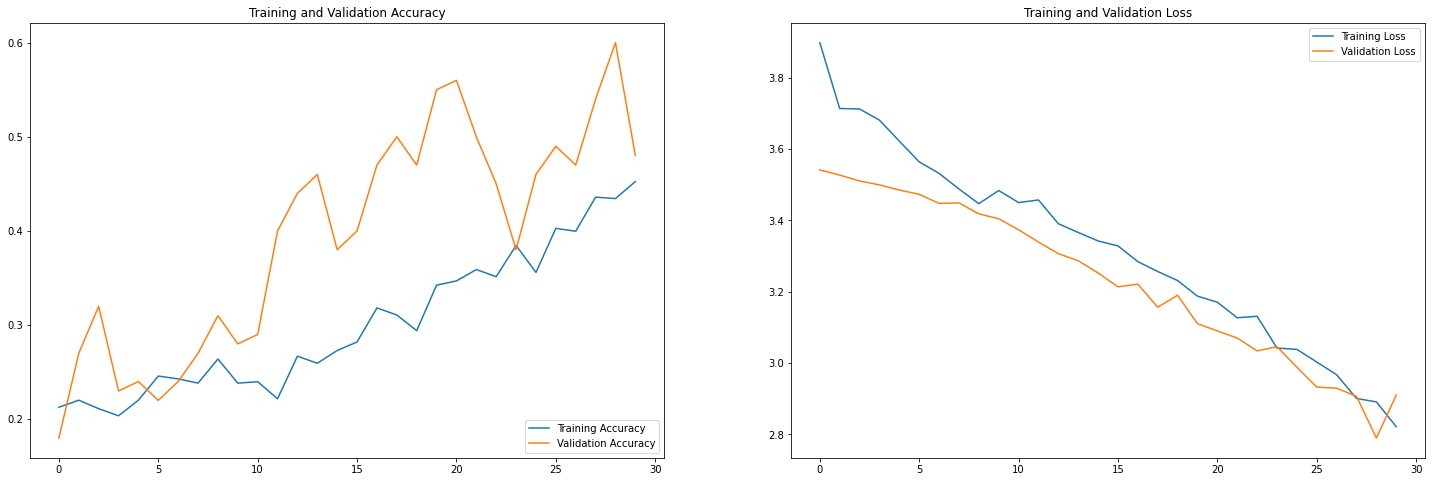

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, Conv3D_model_history)

### Analysis 


*   categorical_accuracy % : 45 %
*   val_categorical_accuracy % : 48 %
*   COmplexity is increased and Model Is under performing



## **Model 9: Conv3D + ADAM + Data Augmentation**

In [ ]:
reset_random_seeds()

In [ ]:
        batch_size=30
        num_epochs=30
        image_x_shape = 100
        image_y_shape = 100

        model3D_ADAM_DA = Sequential()
      

        model3D_ADAM_DA.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
        model3D_ADAM_DA.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM_DA.add(BatchNormalization())
        
        model3D_ADAM_DA.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM_DA.add(BatchNormalization())
        
        model3D_ADAM_DA.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM_DA.add(BatchNormalization())
        
        
        model3D_ADAM_DA.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model3D_ADAM_DA.add(BatchNormalization())
        
        model3D_ADAM_DA.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model3D_ADAM_DA.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model3D_ADAM_DA.add(BatchNormalization())
        
        model3D_ADAM_DA.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model3D_ADAM_DA.add(BatchNormalization())
        
       
        model3D_ADAM_DA.add(Dropout(0.25))
        model3D_ADAM_DA.add(Flatten())
        model3D_ADAM_DA.add(Dense(256,activation='relu'))
        model3D_ADAM_DA.add(Dropout(0.5))
        model3D_ADAM_DA.add(Dense(128,activation='relu'))
        model3D_ADAM_DA.add(Dropout(0.5))
        model3D_ADAM_DA.add(Dense(64,activation='relu'))
        model3D_ADAM_DA.add(Dropout(0.5))
        model3D_ADAM_DA.add(Dense(5, activation='softmax'))

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)
Conv3D_optimiser = optimizers.Adam() #write your optimizer
model3D_ADAM_DA.compile(optimizer=Conv3D_optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [ ]:
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


In [ ]:
conv3d_model_history_adam_aug = model3D_ADAM_DA.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 3.2253 - categorical_accuracy: 0.2255Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-0616_53_40.912067/model-00001-3.22532-0.22549-2.62166-0.19000.h5
23/23 [==============================] - 177s 8s/step - loss: 3.2253 - categorical_accuracy: 0.2255 - val_loss: 2.6217 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 2.6416 - categorical_accuracy: 0.2142
Epoch 2: saving model to model_init_2022-09-0616_53_40.912067/model-00002-2.64156-0.21418-2.50085-0.21000.h5
23/23 [==============================] - 185s 8s/step - loss: 2.6416 - categorical_accuracy: 0.2142 - val_loss: 2.5008 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 2.5130 - categorical_accuracy: 0.2383
Epoch 3: saving model to

In [ ]:
print (model3D_ADAM_DA.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_39 (Conv3D)          (None, 10, 100, 100, 8)   656       
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 5, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_39 (Bat  (None, 5, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_40 (Conv3D)          (None, 5, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 2, 25, 25, 16)    0         
 g3D)                                                            
                                                      

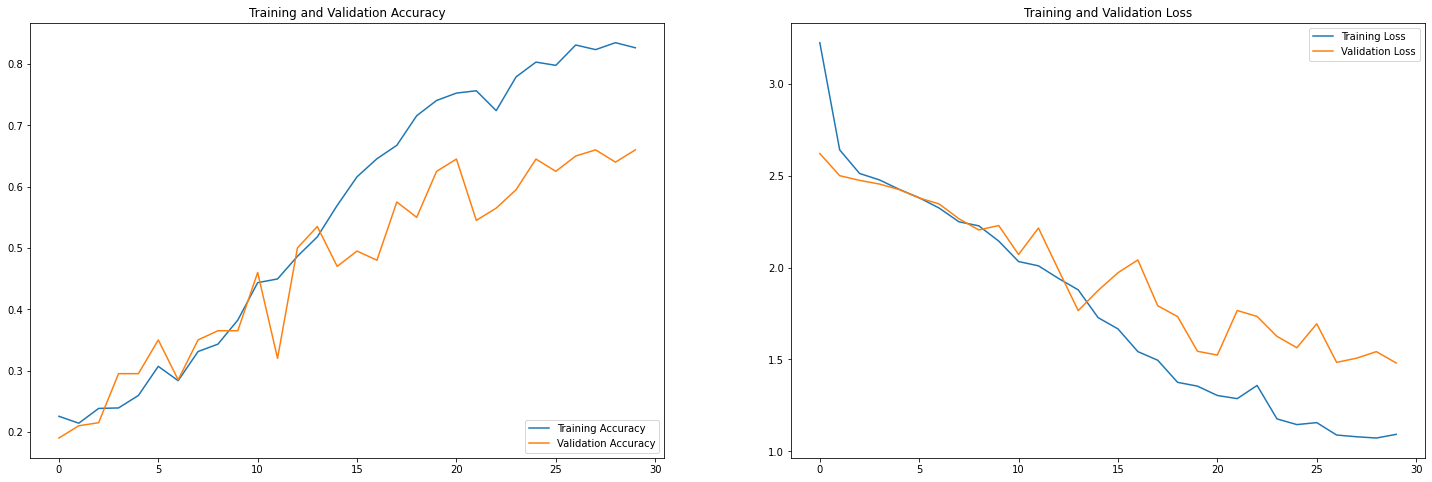

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, conv3d_model_history_adam_aug)

### Analysis 


*   categorical_accuracy % : 82 %
*   val_categorical_accuracy % : 66 %
*   Seems to be underfit 



## Model 10: Conv3D + ADAM + Data Augmentation (ImageSize=160)

In [ ]:
 reset_random_seeds()

In [ ]:
        batch_size=30
        num_epochs=30
        image_x_shape = 160
        image_y_shape = 160


        model3D_ADAM_DA_Img = Sequential()
      

        model3D_ADAM_DA_Img.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, image_x_shape, image_y_shape, 3)))
        model3D_ADAM_DA_Img.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM_DA_Img.add(BatchNormalization())
        
        model3D_ADAM_DA_Img.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA_Img.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM_DA_Img.add(BatchNormalization())
        
        model3D_ADAM_DA_Img.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA_Img.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM_DA_Img.add(BatchNormalization())
        
        
        model3D_ADAM_DA_Img.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA_Img.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model3D_ADAM_DA_Img.add(BatchNormalization())
        
        model3D_ADAM_DA_Img.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model3D_ADAM_DA_Img.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model3D_ADAM_DA_Img.add(BatchNormalization())
        
        model3D_ADAM_DA_Img.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA_Img.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model3D_ADAM_DA_Img.add(BatchNormalization())
        
       
        model3D_ADAM_DA_Img.add(Dropout(0.25))
        model3D_ADAM_DA_Img.add(Flatten())
        model3D_ADAM_DA_Img.add(Dense(256,activation='relu'))
        model3D_ADAM_DA_Img.add(Dropout(0.5))
        model3D_ADAM_DA_Img.add(Dense(128,activation='relu'))
        model3D_ADAM_DA_Img.add(Dropout(0.5))
        model3D_ADAM_DA_Img.add(Dense(64,activation='relu'))
        model3D_ADAM_DA_Img.add(Dropout(0.5))
        model3D_ADAM_DA_Img.add(Dense(5, activation='softmax'))

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)
Conv3D_optimiser = optimizers.Adam() #write your optimizer
model3D_ADAM_DA_Img.compile(optimizer=Conv3D_optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3D_ADAM_DA_Img.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_45 (Conv3D)          (None, 10, 160, 160, 8)   656       
                                                                 
 max_pooling3d_45 (MaxPoolin  (None, 5, 80, 80, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_45 (Bat  (None, 5, 80, 80, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_46 (Conv3D)          (None, 5, 80, 80, 16)     3472      
                                                                 
 max_pooling3d_46 (MaxPoolin  (None, 2, 40, 40, 16)    0         
 g3D)                                                            
                                                      

In [ ]:
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


In [ ]:
conv3d_model_history_adam_aug = model3D_ADAM_DA_Img.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 3.4586 - categorical_accuracy: 0.1998Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-0616_53_40.912067/model-00001-3.45861-0.19985-2.62809-0.18500.h5
23/23 [==============================] - 203s 9s/step - loss: 3.4586 - categorical_accuracy: 0.1998 - val_loss: 2.6281 - val_categorical_accuracy: 0.1850 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 2.6849 - categorical_accuracy: 0.2210
Epoch 2: saving model to model_init_2022-09-0616_53_40.912067/model-00002-2.68493-0.22097-2.51182-0.19000.h5
23/23 [==============================] - 203s 9s/step - loss: 2.6849 - categorical_accuracy: 0.2210 - val_loss: 2.5118 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 2.5711 - categorical_accuracy: 0.2353
Epoch 3: saving model to

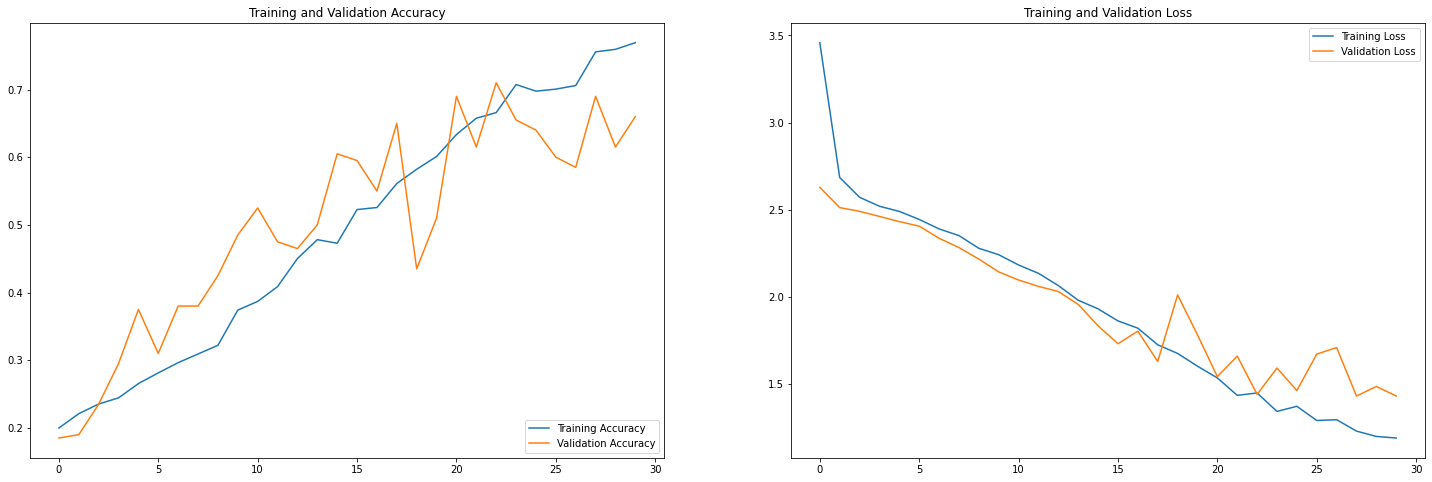

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, conv3d_model_history_adam_aug)

### Analysis 


*   categorical_accuracy % : 76 %
*   val_categorical_accuracy % : 66 %
*   Seems to be overfit 



##Model 11: **Conv3D + ADAM + Data Augmentation (ImageSize=160, Epochs=50)**

In [ ]:


reset_random_seeds()
batch_size=30
num_epochs=50
image_x_shape = 160
image_y_shape = 160

In [ ]:

        model3D_ADAM_DA_Img_epoch = Sequential()
      

        model3D_ADAM_DA_Img_epoch.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, image_x_shape, image_y_shape, 3)))
        model3D_ADAM_DA_Img_epoch.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM_DA_Img_epoch.add(BatchNormalization())
        
        model3D_ADAM_DA_Img_epoch.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA_Img_epoch.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM_DA_Img_epoch.add(BatchNormalization())
        
        model3D_ADAM_DA_Img_epoch.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA_Img_epoch.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model3D_ADAM_DA_Img_epoch.add(BatchNormalization())
        
        
        model3D_ADAM_DA_Img_epoch.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA_Img_epoch.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model3D_ADAM_DA_Img_epoch.add(BatchNormalization())
        
        model3D_ADAM_DA_Img_epoch.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model3D_ADAM_DA_Img_epoch.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model3D_ADAM_DA_Img_epoch.add(BatchNormalization())
        
        model3D_ADAM_DA_Img_epoch.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model3D_ADAM_DA_Img_epoch.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model3D_ADAM_DA_Img_epoch.add(BatchNormalization())


        
       
        model3D_ADAM_DA_Img_epoch.add(Dropout(0.25))
        model3D_ADAM_DA_Img_epoch.add(Flatten())
        model3D_ADAM_DA_Img_epoch.add(Dense(256,activation='relu'))
        model3D_ADAM_DA_Img_epoch.add(Dropout(0.5))
        model3D_ADAM_DA_Img_epoch.add(Dense(128,activation='relu'))
        model3D_ADAM_DA_Img_epoch.add(Dropout(0.5))
        model3D_ADAM_DA_Img_epoch.add(Dense(64,activation='relu'))
        model3D_ADAM_DA_Img_epoch.add(Dropout(0.5))

        model3D_ADAM_DA_Img_epoch.add(Dense(5, activation='softmax'))

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)
Conv3D_optimiser = optimizers.Adam() #write your optimizer
model3D_ADAM_DA_Img_epoch.compile(optimizer=Conv3D_optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3D_ADAM_DA_Img_epoch.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_51 (Conv3D)          (None, 10, 160, 160, 8)   656       
                                                                 
 max_pooling3d_51 (MaxPoolin  (None, 5, 80, 80, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_51 (Bat  (None, 5, 80, 80, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_52 (Conv3D)          (None, 5, 80, 80, 16)     3472      
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 2, 40, 40, 16)    0         
 g3D)                                                            
                                                     

In [ ]:
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


In [ ]:
conv3d_model_history_adam_aug_160_ep50 = model3D_ADAM_DA_Img_epoch.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 3.4614 - categorical_accuracy: 0.2134Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-0616_53_40.912067/model-00001-3.46138-0.21342-2.62504-0.24500.h5
23/23 [==============================] - 199s 9s/step - loss: 3.4614 - categorical_accuracy: 0.2134 - val_loss: 2.6250 - val_categorical_accuracy: 0.2450 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 2.7070 - categorical_accuracy: 0.2164
Epoch 2: saving model to model_init_2022-09-0616_53_40.912067/model-00002-2.70699-0.21644-2.51046-0.24000.h5
23/23 [==============================] - 203s 9s/step - loss: 2.7070 - categorical_accuracy: 0.2164 - val_loss: 2.5105 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 2.5776 - categorical_accuracy: 0.2368
Epoch 3: saving model to

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, conv3d_model_history_adam_aug_160_ep50)

NameError: ignored

### Analysis 


*   categorical_accuracy % : 74 %
*   val_categorical_accuracy % : 64 %
*   Seems to be overfit 



## Model 12: Transfer Learning VGG16

In [ ]:
# Import the inception model 
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input


Some reference: 
https://github.com/mobassir94/Practicing-Tensorflow/blob/master/kaggle_Pneumonia_Detection.ipynb
https://www.researchgate.net/post/How-to-implement-Pre-trained-models-with-only-modifications-in-the-output-layer
https://github.com/mobassir94/Practicing-Tensorflow/blob/master/kaggle_pneumonia(overfitted).ipynb
https://keras.io/api/applications/vgg/
https://stackoverflow.com/questions/66973552/vgg16-network-for-multiple-inputs-images
https://stackoverflow.com/questions/61036435/how-to-feed-multiple-images-at-once-in-vgg16-cnn

In [ ]:
## Loading VGG16 model
# Use Include_top=False to remove the classification layer that was trained on the ImageNet dataset 
# Set the model as not trainable. 
base_model = VGG16(weights='imagenet', include_top=False)
base_model.trainable = False ## Not trainable weights

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#VGG 16 model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# Create a new model - fully-connected layers).
# Bootstrapping a new model onto the pretrained layers.

model_9 = Sequential([TimeDistributed(base_model, input_shape=(10, 100, 100, 3))])

for layer in model_9.layers:
    layer.trainable = False

model_9.add(TimeDistributed(BatchNormalization()))
model_9.add(TimeDistributed(MaxPooling2D(2,2)))
model_9.add(TimeDistributed(Flatten()))

model_9.add(LSTM(64))
model_9.add(Dropout(0.5))

model_9.add(Dense(64,activation='relu'))
model_9.add(Dropout(0.5))

model_9.add(Dense(num_classes, activation='softmax'))


In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=False)
val_generator = generator(val_path, val_doc, batch_size,augment=False)

optimiser = Adam(learning_rate=0.001)

model_9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_9.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 3, 3, 512)    14714688  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 3, 3, 512)    2048      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 1, 1, 512)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 512)          0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                1

In [ ]:
batch_size = 30
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


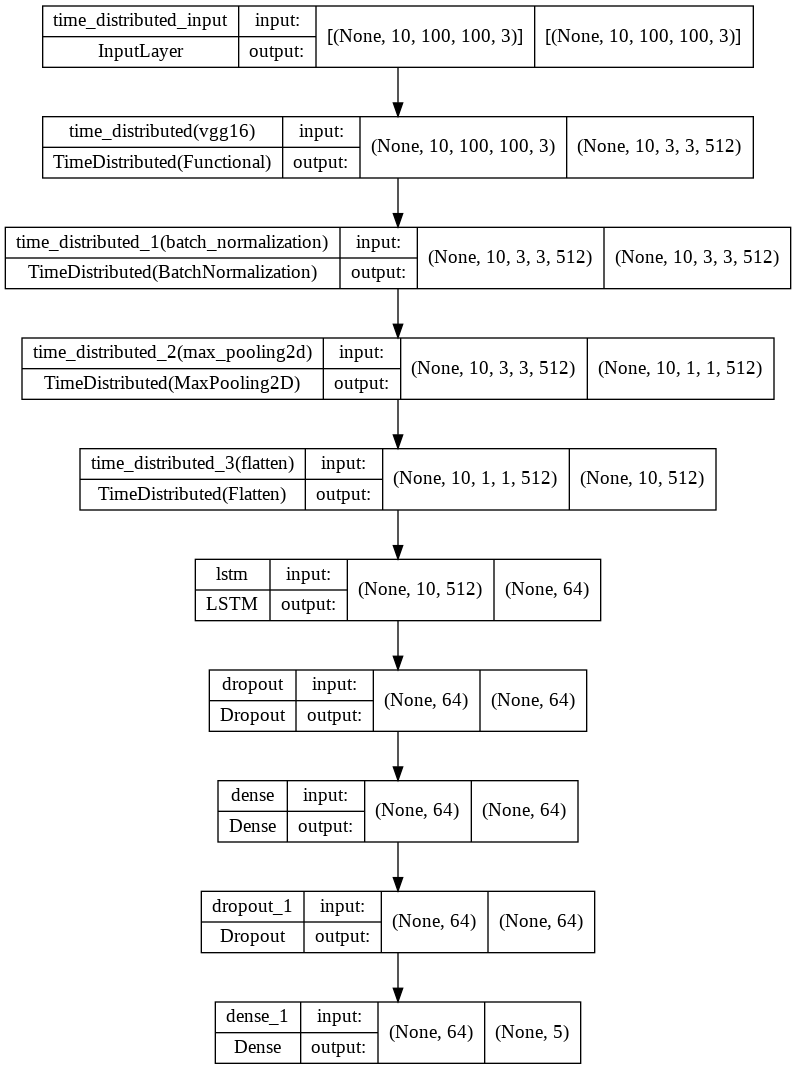

In [ ]:
dot_img_file = './model_1.png'
tf.keras.utils.plot_model(model_9, to_file=dot_img_file, show_shapes=True)

In [ ]:
vgg16_history = model_9.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6989 - categorical_accuracy: 0.2247Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-0903_57_26.751923/model-00001-1.69894-0.22474-1.57890-0.30000.h5
23/23 [==============================] - 99s 4s/step - loss: 1.6989 - categorical_accuracy: 0.2247 - val_loss: 1.5789 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.5641 - categorical_accuracy: 0.2836
Epoch 2: saving model to model_init_2022-09-0903_57_26.751923/model-00002-1.56407-0.28356-1.53420-0.43000.h5
23/23 [==============================] - 82s 4s/step - loss: 1.5641 - categorical_accuracy: 0.2836 - val_loss: 1.5342 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.4618 - categorical_accuracy: 0.3906
Epoch 3: saving model to m

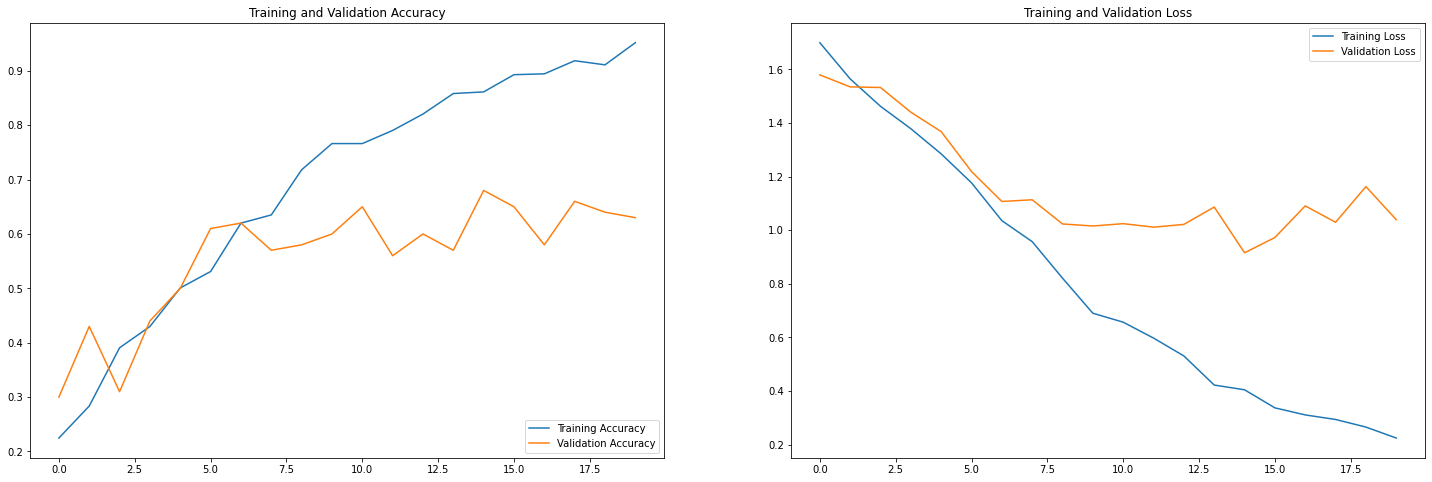

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, vgg16_history)

### Analysis 


*   categorical_accuracy % : 97 %
*   val_categorical_accuracy % : 62 %
*   Seems to be overfit 



## Model 13: Transfer Learning using mobilenet + LSTM

In [ ]:
# Import the mobilenet model 
from keras.applications import mobilenet

In [ ]:
base_mobile = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model_10 = Sequential([TimeDistributed(base_mobile, input_shape=(10, 100, 100, 3))])

for layer in model_10.layers:
    layer.trainable = False

model_10.add(TimeDistributed(BatchNormalization()))
model_10.add(TimeDistributed(MaxPooling2D(2,2)))
model_10.add(TimeDistributed(Flatten()))

model_10.add(LSTM(64))
model_10.add(Dense(64,activation='relu'))
model_10.add(Dropout(0.2))

model_10.add(Dense(num_classes, activation='softmax'))
      

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=False)
val_generator = generator(val_path, val_doc, batch_size,augment=False)

optimiser = Adam(learning_rate=0.001)

model_10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_10.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_62 (TimeDi  (None, 10, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_63 (TimeDi  (None, 10, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, 10, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 10, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 64)              

In [ ]:
batch_size = 30
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


In [ ]:
mobilnet_his = model_10.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.5426 - categorical_accuracy: 0.3077Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-0917_43_48.176850/model-00001-1.54264-0.30769-1.33157-0.48000.h5
23/23 [==============================] - 100s 4s/step - loss: 1.5426 - categorical_accuracy: 0.3077 - val_loss: 1.3316 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.0586 - categorical_accuracy: 0.6531
Epoch 2: saving model to model_init_2022-09-0917_43_48.176850/model-00002-1.05864-0.65309-1.12597-0.53000.h5
23/23 [==============================] - 93s 4s/step - loss: 1.0586 - categorical_accuracy: 0.6531 - val_loss: 1.1260 - val_categorical_accuracy: 0.5300 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.6824 - categorical_accuracy: 0.8069
Epoch 3: saving model to 

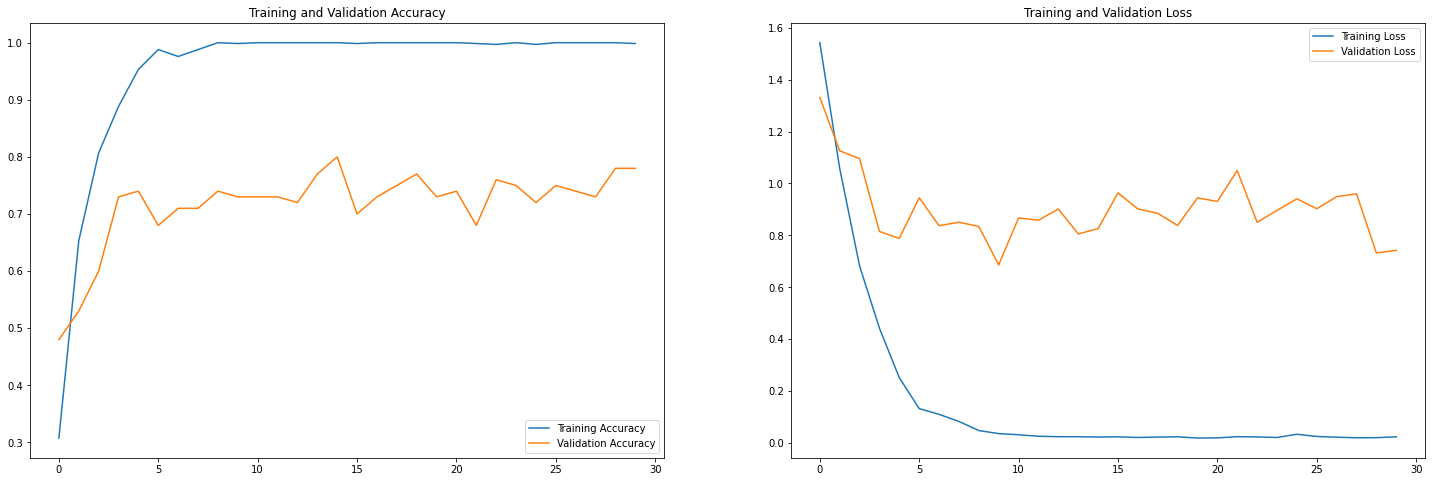

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, mobilnet_his)

### Analysis 


*   categorical_accuracy % : 97 %
*   val_categorical_accuracy % : 62 %
*   Seems to be overfit 



## Model 14: Transfer Learning MobileNet + GRU + Augmentation

In [ ]:
reset_random_seeds()
img_idx = list(range(0, 30, 3))

In [ ]:
model_11 = Sequential([TimeDistributed(base_mobile, input_shape=(len(img_idx), 100, 100, 3))])

model_11.add(TimeDistributed(BatchNormalization()))

model_11.add(TimeDistributed(MaxPooling2D((3, 3))))

model_11.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
model_11.add(TimeDistributed(Activation('relu')))

model_11.add(Dropout(0.25))

model_11.add(TimeDistributed(Flatten()))

model_11.add(GRU(64))
model_11.add(Dense(64,activation='relu'))
model_11.add(Dropout(0.5))

model_11.add(Dense(num_classes, activation='softmax'))


In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

optimiser = Adam(learning_rate=0.001)

model_11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_11.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 1, 1, 64)     589888    
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 1, 1, 64)     0

In [ ]:
batch_size = 30
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


In [ ]:
mobilnet_gru_hist = model_11.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 10
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.5044 - categorical_accuracy: 0.3500Source path =  ./Project_data/val ; batch size = 10

Epoch 1: saving model to model_init_2022-09-1113_47_21.756992/model-00001-1.50438-0.35000-1.40122-0.31250.h5
23/23 [==============================] - 94s 3s/step - loss: 1.5044 - categorical_accuracy: 0.3500 - val_loss: 1.4012 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.1902 - categorical_accuracy: 0.4848
Epoch 2: saving model to model_init_2022-09-1113_47_21.756992/model-00002-1.19017-0.48478-0.83945-0.71250.h5
23/23 [==============================] - 63s 3s/step - loss: 1.1902 - categorical_accuracy: 0.4848 - val_loss: 0.8395 - val_categorical_accuracy: 0.7125 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.0786 - categorical_accuracy: 0.5919
Epoch 3: saving model to m

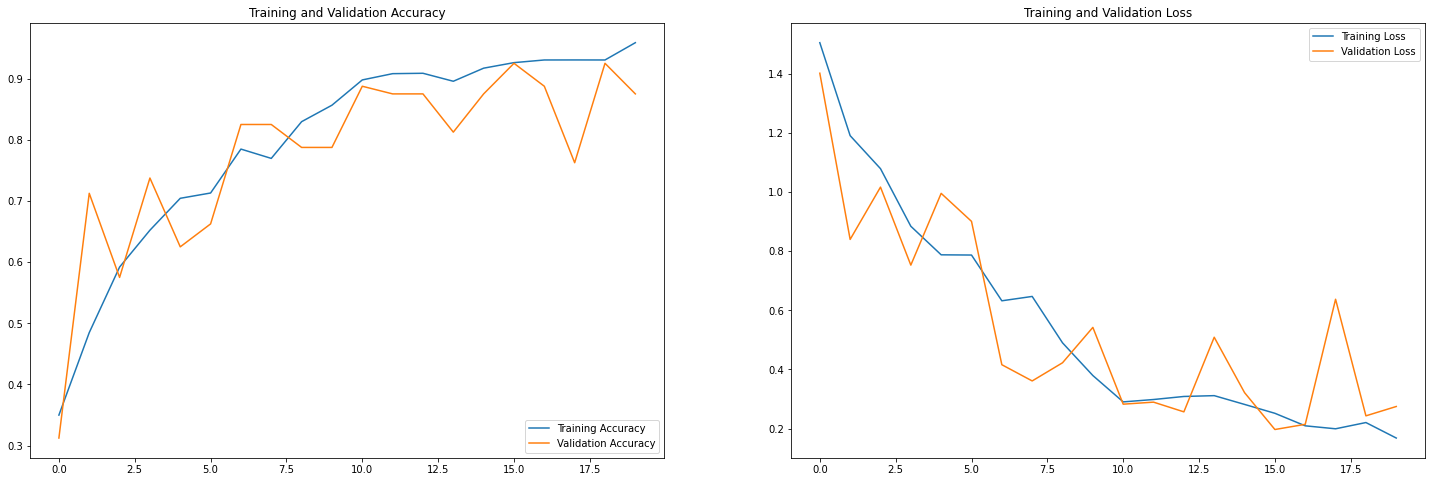

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, mobilnet_gru_hist)

### Analysis 


*   categorical_accuracy % : 96 %
*   val_categorical_accuracy % : 88 %


## Model 15: Transfer Learning MobileNet + GRU + Augmentation + More Layers + Img Size

In [ ]:
reset_random_seeds()

In [ ]:
model_12 = Sequential([TimeDistributed(base_mobile, input_shape=(10, 100, 100, 3))])

for layer in model_12.layers:
    layer.trainable = False

model_12.add(TimeDistributed(BatchNormalization()))
model_12.add(TimeDistributed(MaxPooling2D(2,2)))
model_12.add(TimeDistributed(Flatten()))

model_12.add(LSTM(64))
model_12.add(Dense(64,activation='relu'))
model_12.add(Dropout(0.2))

model_12.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_12 = Sequential([TimeDistributed(base_mobile, input_shape=(10, 100, 100, 3))])

for layer in model_12.layers:
    layer.trainable = False

model_12.add(TimeDistributed(BatchNormalization()))
model_12.add(TimeDistributed(MaxPooling2D(2,2)))


#model_12.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
model_12.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
model_12.add(TimeDistributed(Activation('relu')))
model_12.add(TimeDistributed(BatchNormalization()))
model_12.add(Dropout(0.2))
#model_12.add(TimeDistributed(MaxPooling2D((2, 2), strides = (2,2))))
model_12.add(TimeDistributed(Flatten()))

model_12.add(GRU(64))
model_12.add(Dense(64,activation='relu'))
model_12.add(Dropout(0.2))

model_12.add(Dense(num_classes, activation='softmax'))

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

optimiser = Adam(learning_rate=0.001)

model_12.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_12.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_96 (TimeDi  (None, 10, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_97 (TimeDi  (None, 10, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_98 (TimeDi  (None, 10, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_99 (TimeDi  (None, 10, 1, 1, 64)     589888    
 stributed)                                                      
                                                                 
 time_distributed_100 (TimeD  (None, 10, 1, 1, 64)   

In [ ]:
batch_size = 30
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


In [ ]:
mobilnet_layers = model_12.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.8229 - categorical_accuracy: 0.4442Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-1006_36_30.192153/model-00001-1.82293-0.44419-1.40645-0.45000.h5
23/23 [==============================] - 171s 8s/step - loss: 1.8229 - categorical_accuracy: 0.4442 - val_loss: 1.4065 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.9583 - categorical_accuracy: 0.7247
Epoch 2: saving model to model_init_2022-09-1006_36_30.192153/model-00002-0.95829-0.72474-1.29122-0.58000.h5
23/23 [==============================] - 156s 7s/step - loss: 0.9583 - categorical_accuracy: 0.7247 - val_loss: 1.2912 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.6430 - categorical_accuracy: 0.8394
Epoch 3: saving model to

In [ ]:
#plotting graph to visualize model performance
plot_model_performance(num_epochs, mobilnet_gru_hist)

NameError: ignored

### Analysis 


*   categorical_accuracy % : 97 %
*   val_categorical_accuracy % : 71 %
*   Seems to be overfit 



## Model 16: Transfer Learning MobileNet + GRU + No Augmentation + More Layers

In [ ]:
reset_random_seeds()

In [ ]:
model_16 = Sequential([TimeDistributed(base_mobile, input_shape=(10, 100, 100, 3))])

for layer in model_16.layers:
    layer.trainable = False

model_16.add(TimeDistributed(BatchNormalization()))
model_16.add(TimeDistributed(MaxPooling2D(2,2)))


#model_12.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
model_16.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
model_16.add(TimeDistributed(Activation('relu')))
model_16.add(TimeDistributed(BatchNormalization()))
model_16.add(Dropout(0.2))
#model_12.add(TimeDistributed(MaxPooling2D((2, 2), strides = (2,2))))

#model_12.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
model_16.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
model_16.add(TimeDistributed(Activation('relu')))
model_16.add(TimeDistributed(BatchNormalization()))
model_16.add(Dropout(0.2))
#model_12.add(TimeDistributed(MaxPooling2D((2, 2), strides = (2,2))))

model_16.add(TimeDistributed(Flatten()))

model_16.add(LSTM(64))
model_16.add(Dense(64,activation='relu'))
model_16.add(Dropout(0.2))

model_16.add(Dense(num_classes, activation='softmax'))

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

optimiser = Adam(learning_rate=0.001)

model_16.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_16.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_140 (TimeD  (None, 10, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_141 (TimeD  (None, 10, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_142 (TimeD  (None, 10, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_143 (TimeD  (None, 10, 1, 1, 128)    1179776   
 istributed)                                                     
                                                                 
 time_distributed_144 (TimeD  (None, 10, 1, 1, 128)  

In [ ]:
batch_size = 30
save_train_model(batch_size, num_train_sequences)

Used batch_size:30 and num_train_sequences 663 


In [ ]:
mobilnet_layers = model_16.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=None,
                              workers=1,
                              initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.8020 - categorical_accuracy: 0.4563Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-09-1006_36_30.192153/model-00001-2.80198-0.45626-1.79164-0.59000.h5
23/23 [==============================] - 168s 7s/step - loss: 2.8020 - categorical_accuracy: 0.4563 - val_loss: 1.7916 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.2677 - categorical_accuracy: 0.7594
Epoch 2: saving model to model_init_2022-09-1006_36_30.192153/model-00002-1.26766-0.75943-1.63790-0.54500.h5
23/23 [==============================] - 162s 7s/step - loss: 1.2677 - categorical_accuracy: 0.7594 - val_loss: 1.6379 - val_categorical_accuracy: 0.5450 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.7904 - categorical_accuracy: 0.8673
Epoch 3: saving model to

In [1]:
#plotting graph to visualize model performance
#plot_model_performance(num_epochs, mobilnet_gru_hist)

### Analysis 


*   categorical_accuracy % : 97 %
*   val_categorical_accuracy % : 71 %
*   Seems to be overfit 

